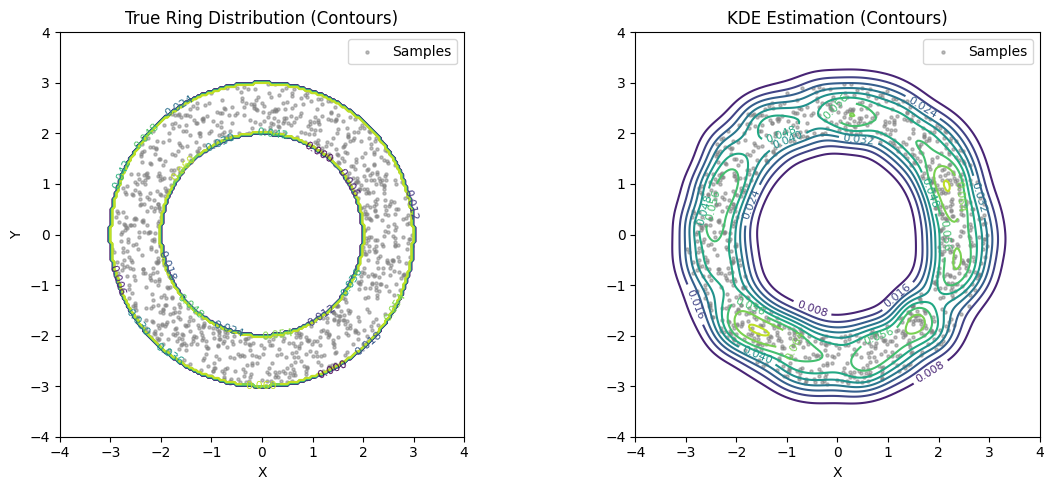

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

def generate_ring_data(n_samples=500, r_min=2.0, r_max=3.0, random_seed=42):
    """
    生成一个介于 r_min 和 r_max 之间均匀分布的环形数据 (二维)。
    """
    np.random.seed(random_seed)

    # 在 [r_min, r_max] 间均匀采样半径
    radii = np.random.uniform(r_min, r_max, size=n_samples)
    # 在 [0, 2π) 间均匀采样角度
    thetas = np.random.uniform(0, 2*np.pi, size=n_samples)

    # 转为 x, y
    xs = radii * np.cos(thetas)
    ys = radii * np.sin(thetas)

    data = np.column_stack([xs, ys])
    return data

def true_ring_pdf(x, y, r_min, r_max):
    """
    给定 (x, y)，返回“环形均匀分布”的真实 PDF 值。
    若 sqrt(x^2 + y^2) 在 [r_min, r_max] 之间，则值为 1 / 区域面积；
    否则为 0。
    """
    r = np.sqrt(x**2 + y**2)
    area = np.pi * (r_max**2 - r_min**2)  # 环带的面积
    # 如果在环带内，pdf = 1/area；环带外，pdf = 0
    return np.where((r >= r_min) & (r <= r_max),
                    1.0 / area,
                    0.0)

def main():
    # ----------------------
    # 1) 生成环形数据
    # ----------------------
    r_min, r_max = 2.0, 3.0
    X = generate_ring_data(n_samples=1000, r_min=r_min, r_max=r_max, random_seed=42)

    # ----------------------
    # 2) 核密度估计 (KDE)
    # ----------------------
    kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(X)

    # ----------------------
    # 3) 准备网格，计算：
    #    - 真实分布的 pdf
    #    - 核密度估计的 pdf
    # ----------------------
    x_min, x_max = -4, 4
    y_min, y_max = -4, 4
    grid_size = 200
    Xgrid, Ygrid = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size)
    )
    # 变形为 (N, 2)
    grid_points = np.vstack([Xgrid.ravel(), Ygrid.ravel()]).T

    # --- (a) 计算真实分布的 PDF ---
    # 调用 true_ring_pdf 并 reshape
    Z_true = true_ring_pdf(grid_points[:,0], grid_points[:,1], r_min, r_max)
    Z_true = Z_true.reshape(Xgrid.shape)

    # --- (b) 计算 KDE 的 PDF ---
    log_density = kde.score_samples(grid_points)  # 返回 log(pdf)
    Z_kde = np.exp(log_density).reshape(Xgrid.shape)

    # ----------------------
    # 4) 可视化对比
    #    左图：真实分布的等高线
    #    右图：KDE 估计的等高线
    # ----------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 左图：真实分布
    ax1 = axes[0]
    ax1.scatter(X[:, 0], X[:, 1], s=5, c='gray', alpha=0.5, label='Samples')
    contour_true = ax1.contour(Xgrid, Ygrid, Z_true, levels=10, cmap='viridis')
    ax1.clabel(contour_true, inline=1, fontsize=8)
    ax1.set_title("True Ring Distribution (Contours)")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.axis('equal')
    ax1.legend()

    # 右图：KDE 分布
    ax2 = axes[1]
    ax2.scatter(X[:, 0], X[:, 1], s=5, c='gray', alpha=0.5, label='Samples')
    contour_kde = ax2.contour(Xgrid, Ygrid, Z_kde, levels=10, cmap='viridis')
    ax2.clabel(contour_kde, inline=1, fontsize=8)
    ax2.set_title("KDE Estimation (Contours)")
    ax2.set_xlabel("X")
    ax2.axis('equal')
    ax2.legend()

    ax1.set_aspect('equal', adjustable='box')
    ax2.set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


# explicite score matching

Epoch 0, Loss: 0.4047
Epoch 20, Loss: 0.0215
Epoch 40, Loss: 0.0191
Epoch 60, Loss: 0.0160
Epoch 80, Loss: 0.0153
Epoch 100, Loss: 0.0123
Epoch 120, Loss: 0.0111
Epoch 140, Loss: 0.0108
Epoch 160, Loss: 0.0098
Epoch 180, Loss: 0.0095


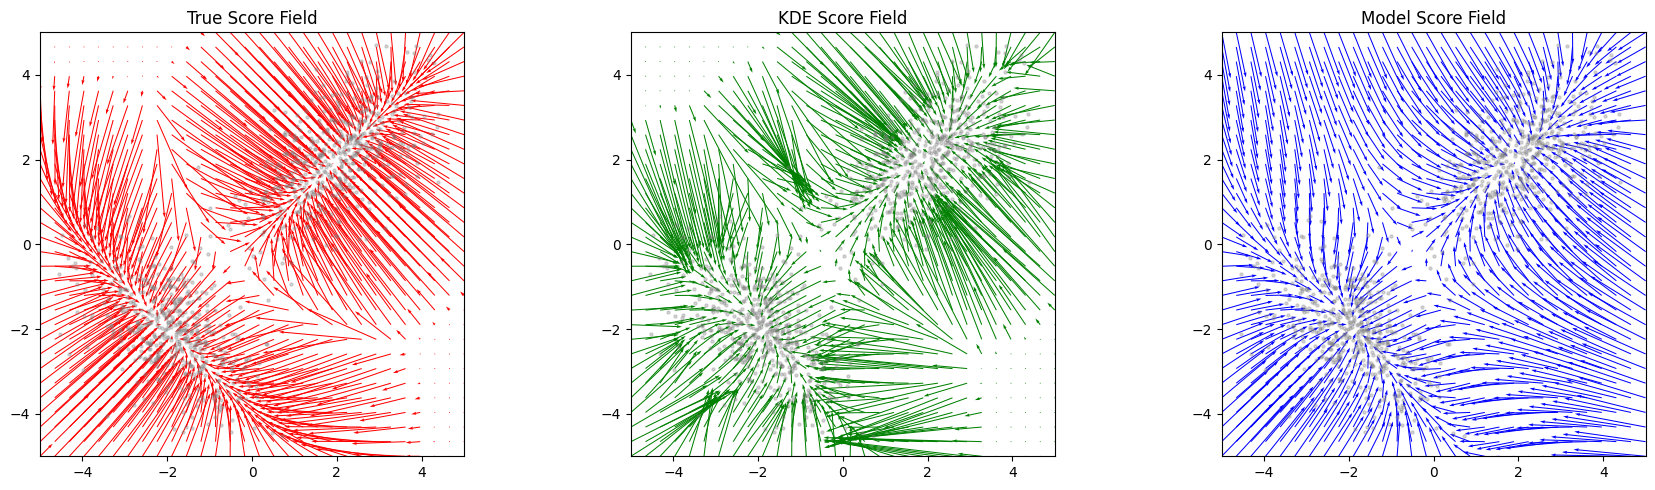

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# =============================================
# 1. 生成示例数据（二维高斯混合分布）
# =============================================
def generate_data(num_samples=1000):
    # 定义两个高斯分布的参数
    weights = [0.5, 0.5]  # 混合权重
    means = [[2, 2], [-2, -2]]
    covs = [[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]]]

    # 生成数据
    data = []
    for _ in range(num_samples):
        # 选择高斯分量
        k = np.random.choice(len(weights), p=weights)
        x = np.random.multivariate_normal(means[k], covs[k])
        data.append(x)
    return np.array(data)

# 生成数据
np.random.seed(42)
data = generate_data(1000)

# =============================================
# 2. 真实梯度计算（解析解）
# =============================================
def true_score(x, weights, means, covs):
    """计算混合高斯分布在点x处的真实梯度"""
    x = np.array(x)
    score = np.zeros_like(x)
    total_p = 0.0

    for w, mu, cov in zip(weights, means, covs):
        # 计算当前高斯分量的概率密度
        inv_cov = np.linalg.inv(cov)
        diff = x - mu
        exponent = -0.5 * diff.T @ inv_cov @ diff
        p = w * np.exp(exponent) / (2*np.pi * np.sqrt(np.linalg.det(cov)))

        # 计算当前分量的梯度
        grad = -inv_cov @ diff
        score += p * grad
        total_p += p

    return score / (total_p + 1e-8)

# =============================================
# 3. KDE梯度计算
# =============================================
class KDE:
    def __init__(self, data, bandwidth=0.5):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.h = bandwidth

    def compute_score(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        diff = x - self.data
        dist_sq = torch.sum(diff**2, dim=1)
        kernel = torch.exp(-dist_sq / (2 * self.h**2))
        grad_numerator = -torch.mean(kernel.unsqueeze(1) * diff / self.h**2, dim=0)
        p = torch.mean(kernel)
        return (grad_numerator / (p + 1e-8)).numpy()

# =============================================
# 4. 定义并训练模型
# =============================================
class ScoreModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.net(x)

# 训练配置
model = ScoreModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
kde = KDE(data, bandwidth=0.5)
dataset = torch.tensor(data, dtype=torch.float32)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# 训练循环
for epoch in range(200):
    total_loss = 0
    for batch in train_loader:
        true_scores = torch.stack([torch.tensor(
            kde.compute_score(x.numpy())) for x in batch])
        pred_scores = model(batch)
        loss = torch.mean((pred_scores - true_scores)**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")

# =============================================
# 5. 三图对比可视化
# =============================================
def plot_combined_fields(data, model, kde, resolution=30):
    plt.figure(figsize=(18, 5))

    # 生成网格
    x = np.linspace(-5, 5, resolution)
    y = np.linspace(-5, 5, resolution)
    X, Y = np.meshgrid(x, y)
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T

    # 计算三个梯度场
    # 1. 真实梯度场
    true_scores = np.array([true_score(p, [0.5,0.5],
                                      [[2,2], [-2,-2]],
                                      [[[1,0.5],[0.5,1]], [[1,-0.5],[-0.5,1]]])
                           for p in grid_points])

    # 2. KDE梯度场
    kde_scores = np.array([kde.compute_score(p) for p in grid_points])

    # 3. 模型预测梯度场
    with torch.no_grad():
        model_scores = model(torch.tensor(grid_points, dtype=torch.float32)).numpy()

    # 绘图设置
    titles = ['True Score Field', 'KDE Score Field', 'Model Score Field']
    scores_list = [true_scores, kde_scores, model_scores]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.quiver(grid_points[:,0], grid_points[:,1],
                  scores_list[i][:,0], scores_list[i][:,1],
                  color=['red','green','blue'][i], scale=25)
        plt.scatter(data[:,0], data[:,1], s=5, alpha=0.3, c='gray')
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        plt.title(titles[i])
        plt.gca().set_aspect('equal')

    plt.tight_layout()
    plt.show()

# 执行可视化
plot_combined_fields(data, model, kde)